## human judgement data
---
examining some of the human judgement data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
human_df = pd.read_csv('human_data.csv')
human_df.head()

,left_file,right_file,response_left
0,'87_kriz_ssim_fc.png','87_kriz_mse_fc.png',1
1,'90_kriz_mse_fc.png','90_kriz_ssim_fc.png',0
2,'163_kriz_ssim_fc.png','163_kriz_mse_fc.png',1
3,'69_kriz_ssim_fc.png','69_kriz_mse_fc.png',1
4,'100_kriz_mse_fc.png','100_kriz_ssim_fc.png',0


---

data in form left image location, right image location, and a binary variable indicating if the subject chose the left (1) or right (0) image as a better representation of the original. note that the order of compression switches randomly.

---

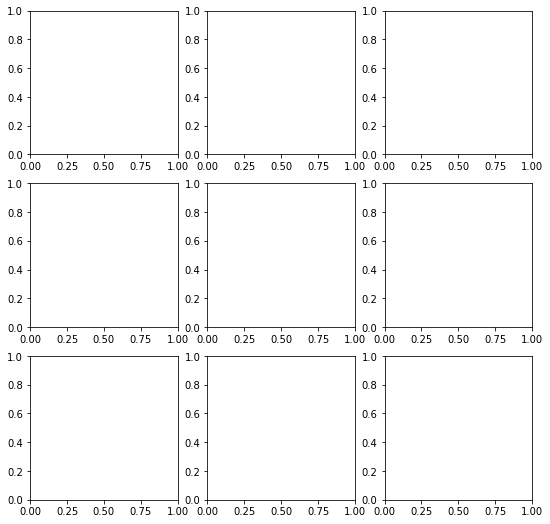

In [5]:
# data sample
f, axarr = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
plt.show()